In [1]:
import os
os.chdir('..')

In [2]:
import detectron2_1

In [3]:
from detectron2.config import get_cfg
from pathlib import Path
from detectron2.engine import DefaultPredictor
import cv2
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from PIL import Image
import numpy as np

# Define Parameters here

In [4]:
img_path = 'data/samples/WechatIMG18.png'
cfg_path = 'output/rcnn_2/config.yaml'
weights_path = 'output/rcnn_2/rcnn_bet365.pth'

conf_threshold = 0.05

print(os.getcwd())

/Users/i537199/Desktop/detectron2-1


# Inference

In [5]:
# Configure weights and confidence threshold
cfg = get_cfg()
cfg.merge_from_file(cfg_path)
cfg.MODEL.DEVICE = 'cpu'
cfg.MODEL.WEIGHTS = weights_path
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = conf_threshold

In [6]:
# Initialize model
predictor = DefaultPredictor(cfg)

Original:


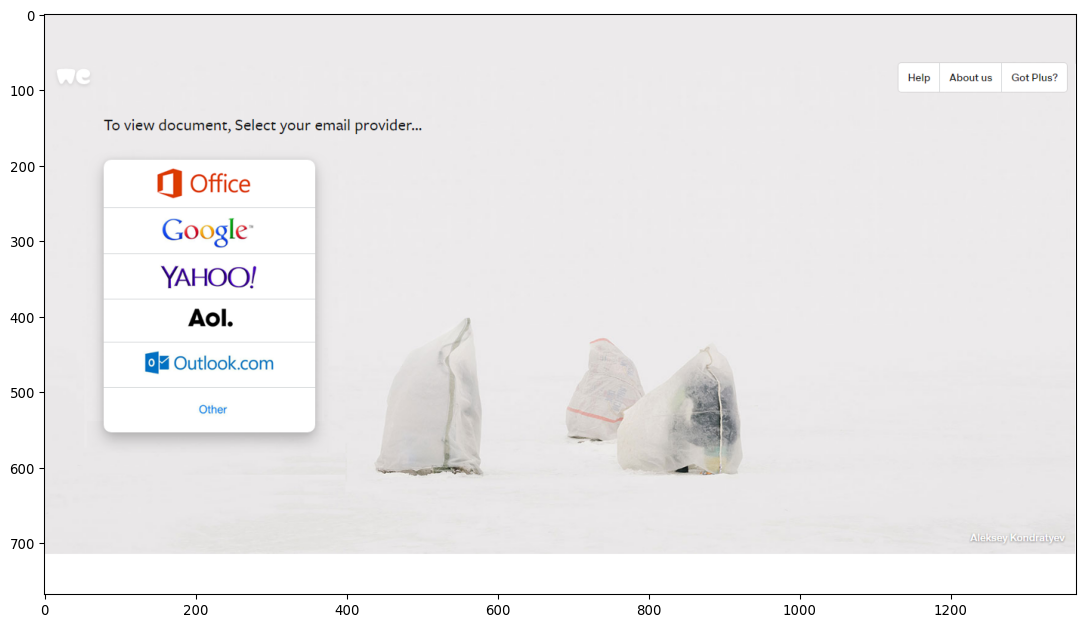

In [7]:
# Test augment the image
import imageio
import imgaug as ia
%matplotlib inline
image = imageio.imread("data/samples/WechatIMG18.png")
print("Original:")
ia.imshow(image)
from imgaug import augmenters as iaa
ia.seed(4)
augmentedImageFunc = iaa.AdditiveGaussianNoise(scale=(30, 90))
image_aug = augmentedImageFunc(image=image)
imageio.imwrite("data/samples/temp.png", image_aug)

# Test random perturbation of image
import random
img = Image.open(img_path)
pixels = img.load()
for i in range(img.size[0]):
    for j in range(img.size[1]):
        randomNum = random.randrange(-10, 10)
        pixels[i,j] = (pixels[i,j][0] + randomNum, pixels[i,j][1] + randomNum, pixels[i,j][2] + randomNum, pixels[i,j][3])
img.save("data/samples/temp.png")

# Load image as numpy array
im = cv2.imread("data/samples/temp.png")

In [8]:
# Perform inference
outputs = predictor(im)

/Users/i537199/opt/anaconda3/lib/python3.8/site-packages/detectron2/layers/wrappers.py:226: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:766.)
  return x.nonzero().unbind(1)


In [9]:
instances = outputs['instances']
print(instances)
pred_classes = instances.pred_classes  # tensor
print()
print(pred_classes)
pred_boxes = instances.pred_boxes  # Boxes object
print(pred_boxes)
scores = instances.scores  # tensor
print(scores)

Instances(num_instances=3, image_height=768, image_width=1366, fields=[pred_boxes: Boxes(tensor([[138.9256, 197.0460, 281.7807, 248.2077],
        [149.0437, 261.8876, 281.6434, 311.3237],
        [143.3837, 198.0347, 289.9505, 367.8194]])), scores: tensor([0.5272, 0.1781, 0.0607]), pred_classes: tensor([1, 1, 1])])

tensor([1, 1, 1])
Boxes(tensor([[138.9256, 197.0460, 281.7807, 248.2077],
        [149.0437, 261.8876, 281.6434, 311.3237],
        [143.3837, 198.0347, 289.9505, 367.8194]]))
tensor([0.5272, 0.1781, 0.0607])


In [10]:
for box in pred_boxes:
    print(box)  # tensor

tensor([138.9256, 197.0460, 281.7807, 248.2077])
tensor([149.0437, 261.8876, 281.6434, 311.3237])
tensor([143.3837, 198.0347, 289.9505, 367.8194])


More info on output format: https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

# Visualization

In [11]:
# Set dataset categories
dataset = cfg.DATASETS.TRAIN[0]
MetadataCatalog.get(dataset).thing_classes = ["box", "logo"]

In [12]:
MetadataCatalog.get(dataset)

namespace(name='benign_bet365',
          json_file=PosixPath('data/benign_data/coco_bet365.json'),
          image_root=PosixPath('data/benign_data/benign_database'),
          evaluator_type='coco',
          thing_classes=['box', 'logo'])

In [13]:
# Draw instance predictions
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(dataset))
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

In [14]:
# Image with instance predictions as numpy array
pred = out.get_image()

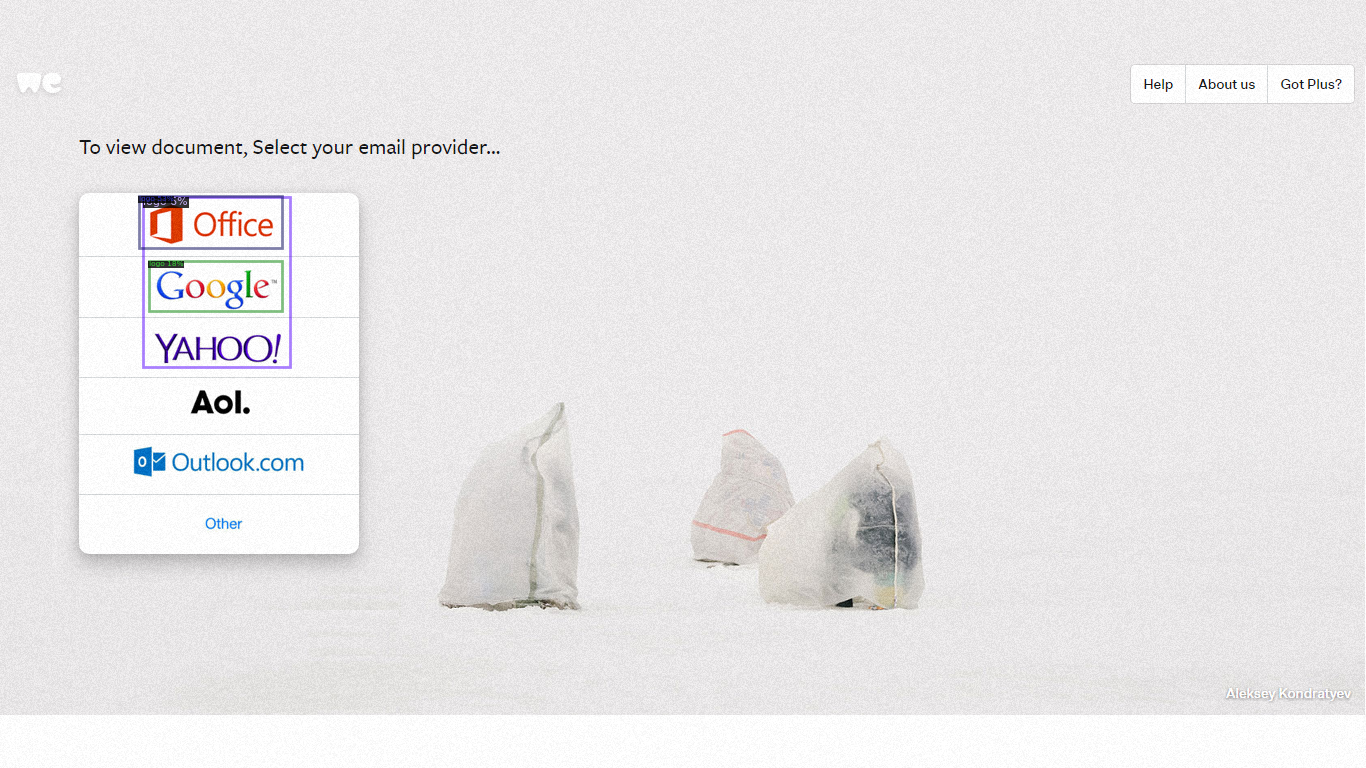

In [15]:
Image.fromarray(pred)

# Inference on Set of Images


In [16]:
from pathlib import Path
from inference import inference

In [ ]:
import json

imageDict = {}
imageAnnotations = {}

with open('data/benign_database/coco_test.json') as json_file:
    data = json.load(json_file)
    for d in data['images']:
        imageID = d["id"]
        imagePath = "data/benign_database/" + d["file_name"]
        imageDict[imagePath] = imageID
    for d in data["annotations"]:
        if d["category_id"] == 2:
            imageID = d["image_id"]
            dimensions = d["bbox"]
            imageAnnotations[imageID] = dimensions
#print(imageDict)
#print(imageAnnotations)


In [17]:
imgs_dir = Path('data/benign_database')
config_path = 'output/rcnn_2/config.yaml'
weights_path = 'output/rcnn_2/rcnn_bet365.pth'
#output_dir = Path('saved')

conf_threshold = 0.05

In [ ]:
for i, img_path in enumerate(imgs_dir.rglob('shot.png')):
    print(img_path)
    company = str(img_path).split("/")[2]
    output_path = str(imgs_dir/".."/"benign_database_random_perturbation"/company/"shot.png")

    """
    inference(
        str(img_path),
        config_path,
        weights_path,
        output_path,
        conf_threshold
    )
    """
    
    # Uniform random attack
    import random
    img = Image.open(img_path)
    pixels = img.load()
    
    imageID = imageDict[str(img_path)]
    # If logo box exists
    if imageID in imageAnnotations:
        imageDimensions = imageAnnotations[imageID]
    # Else, save original image
    else:
        try:
            os.mkdir(imgs_dir/".."/"benign_database_random_perturbation"/company)
        except:
            pass
        img.save(output_path)
        continue
    
    startingX = imageDimensions[0]
    startingY = imageDimensions[1]
    for i in range(imageDimensions[2]):
        for j in range(imageDimensions[3]):
            randomNum = random.randrange(-10, 10)
            if type(pixels[startingX + i, startingY + j]) == tuple and len(pixels[startingX + i, startingY + j]) == 3:
                pixels[startingX + i, startingY + j] = (pixels[startingX + i, startingY + j][0] + randomNum, pixels[startingX + i, startingY + j][1] + randomNum, pixels[startingX + i, startingY + j][2])
            elif type(pixels[startingX + i, startingY + j]) == tuple and len(pixels[startingX + i, startingY + j]) == 4:
                pixels[startingX + i, startingY + j] = (pixels[startingX + i, startingY + j][0] + randomNum, pixels[startingX + i, startingY + j][1] + randomNum, pixels[startingX + i, startingY + j][2] + randomNum, pixels[startingX + i, startingY + j][3])
            elif type(pixels[i,j]) == int:
                pixels[startingX + i, startingY + j] = pixels[startingX + i, startingY + j] + randomNum
    try:
        os.mkdir(imgs_dir/".."/"benign_database_random_perturbation"/company)
    except:
        pass
    img.save(output_path)

    print(f'Saved to {output_path}')

In [21]:
imgs_dir = Path('data/benign_database')
config_path = 'output/rcnn_2/config.yaml'
weights_path = 'output/rcnn_2/rcnn_bet365.pth'
#output_dir = Path('saved')

conf_threshold = 0.05

In [ ]:
for i, img_path in enumerate(imgs_dir.rglob('shot.png')):
    print(img_path)
    company = str(img_path).split("/")[2]
    output_path = str(imgs_dir/".."/"benign_database_random_perturbation_2"/company/"shot.png")

    """
    inference(
        str(img_path),
        config_path,
        weights_path,
        output_path,
        conf_threshold
    )
    """
    
    # Normal random attack
    output_path = str(imgs_dir/".."/"benign_database_random_perturbation_2"/company/"shot.png")
    import random
    img = Image.open(img_path)
    pixels = img.load()
    
    imageID = imageDict[str(img_path)]
    # If logo box exists
    if imageID in imageAnnotations:
        imageDimensions = imageAnnotations[imageID]
    # Else, save original image
    else:
        try:
            os.mkdir(imgs_dir/".."/"benign_database_random_perturbation_2"/company)
        except:
            pass
        img.save(output_path)
        continue
    
    normalRandomArr = np.random.normal(0, 10, (imageDimensions[2], imageDimensions[3]))
    startingX = imageDimensions[0]
    startingY = imageDimensions[1]
    for i in range(imageDimensions[2]):
        for j in range(imageDimensions[3]):
            randomNum = round(normalRandomArr[i][j].item())
            if type(pixels[startingX + i, startingY + j]) == tuple and len(pixels[startingX + i, startingY + j]) == 3:
                pixels[startingX + i, startingY + j] = (pixels[startingX + i, startingY + j][0] + randomNum, pixels[startingX + i, startingY + j][1] + randomNum, pixels[startingX + i, startingY + j][2])
            elif type(pixels[startingX + i, startingY + j]) == tuple and len(pixels[startingX + i, startingY + j]) == 4:
                pixels[startingX + i, startingY + j] = (pixels[startingX + i, startingY + j][0] + randomNum, pixels[startingX + i, startingY + j][1] + randomNum, pixels[startingX + i, startingY + j][2] + randomNum, pixels[startingX + i, startingY + j][3])
            elif type(pixels[i,j]) == int:
                pixels[startingX + i, startingY + j] = pixels[startingX + i, startingY + j] + randomNum
    try:
        os.mkdir(imgs_dir/".."/"benign_database_random_perturbation_2"/company)
    except:
        pass
    img.save(output_path)

    print(f'Saved to {output_path}')